# Statistical Data Analysis - Assignment 2

## Group Members:
1. Ashutosh Chauhan (S20180010017)
2. Pradum Singh (S20180010136)
3.  Utkarsh Ajay Aditya (S20180010182)
4. Vipul Rawat (S20180010192)

In [ ]:
# Install Dependencies
import sys
!{sys.executable} -m pip install numpy scipy matplotlib
# !jupyter nbconvert --to pdf --TemplateExporter.exclude_input=True SDA.ipynb

In [15]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import lines as mlines
from itertools import combinations, takewhile, product
from scipy.stats import norm, chi2, t, f
from mpl_toolkits.mplot3d import Axes3D 
from typing import List, Tuple, Dict
sqrt = math.sqrt

In [16]:
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  #

%%latex
\tableofcontents

In [25]:
%config InlineBackend.figure_format = 'svg'

<b>Approach</b>: The entire code is object oriented.

## Base Distribution Class
A base distribution class is defined which depicts that a distribution will have
parameters, a mean function, a variance function and graph plotting functions. The distributions would be derived from this base class and will have their own unique structure.<br> The graph plotting function, the sample class and the simulation class is common for all the distributions, which has been written only once and it is being utilised by all the derived distribution classes.

In [26]:
class Distribution:
    name = 'Disribution'
    param_count = 0
    """
    Base class for all Distributions
    ---
    Provides Parameters and mean and variance
    and plotting functions for pdf/pmf
    """
    def __init__(self):
        pass
    
    @property
    def params(self) -> str:
        return {}
    
    @property
    def mean(self):
        pass
    
    @property
    def variance(self):
        pass
    
    @property
    def sd(self):
        return sqrt(self.variance)
    
    def plot_pmf(self, domain: Tuple[int, int]):
        # Domain of the Plot
        x = list(range(*domain))
        y = self.__call__(*x)
        plt.plot(x, y, 'o-')
        plt.grid()

    def plot_pdf(self, domain: Tuple[float, float], step=0.01):
        # Domain of the Plot
        x = list(np.arange(*domain, step))
        y = self.__call__(*x)
        plt.plot(x, y, '-')
        plt.grid()
        
    def __call__(self, *domain: float) -> List[float]:
        return domain
    
    def __str__(self):
        return 'Abstract Distribution()'

In [27]:
class Normal(Distribution):
    name = 'Normal'
    param_count = 2
    
    def __init__(self, mean, standard_deviation):
        self._mean = mean
        self.standard_deviation = standard_deviation
        
    @property
    def params(self) -> Dict[str, int]:
        return {'mean': self.mean, 'standard_deviation': self.standard_deviation}
    
    @property
    def mean(self):
        return self._mean
    
    @property
    def variance(self):
        return self.standard_deviation**2
    
    def value(self,sample_size) -> List[float]:
        return [float(np.random.normal(loc=self.mean,scale=self.standard_deviation) ) for _ in range(sample_size)]
    
    def __call__(self, *domain:int) -> List[float]:
        fun = norm(self.mean, math.sqrt(self.variance)).pdf
        return list(map(fun, domain))
    
    def __str__(self):
        return f'Normal(μ={self.mean}, σ={self.standard_deviation})'
    

class Chi2(Distribution):
    name = 'Chi^2'
    param_count = 1
    
    def __init__(self, degrees_of_freedom):
        self.dof = degrees_of_freedom
        
    @property
    def params(self) -> Dict[str, int]:
        return {'degrees_of_freedom': self.dof}
    
    @property
    def mean(self):
        return self.dof
    
    @property
    def variance(self):
        return self.dof * 2
    
    def value(self,sample_size) -> List[float]:
        return np.random.chisquare(self.dof, sample_size)
    
    def __call__(self, *domain:int) -> List[float]:
        return chi2(domain, self.dof)
    
    def __str__(self):
        return f'ChiSquare(df={self.dof})'

class T(Distribution):
    name = 'T'
    param_count = 1
    
    def __init__(self, degrees_of_freedom):
        self.dof = degrees_of_freedom
        
    @property
    def params(self) -> Dict[str, int]:
        return {'degrees_of_freedom': self.dof}
    
    @property
    def mean(self):
        return 0
    
    @property
    def variance(self):
        return self.dof / (self.dof - 2) if self.dof > 2 else float('-inf')
    
    def value(self,sample_size) -> List[float]:
        return np.random.standard_t(self.dof, sample_size)
    
    def __call__(self, *domain:int) -> List[float]:
        return t.pdf(domain, self.dof)
    
    def __str__(self):
        return f'T(df={self.dof})'

class F(Distribution):
    name = 'F'
    param_count = 2
    
    def __init__(self, degrees_of_freedom_1, degrees_of_freedom_2):
        self.dof_1 = degrees_of_freedom_1
        self.dof_2 = degrees_of_freedom_2
        
    @property
    def params(self) -> Dict[str, int]:
        return {'degrees_of_freedom_1': self.dof_1,'degrees_of_freedom_2': self.dof_2}

    @property
    def mean(self):
        self.dof_2 / (self.dof_2 - 2) if self.dof_2 > 2 else None

    @property
    def variance(self):
        d1,d2 = self.dof_1, self.dof_2
        return (2*d2*d2*(d1+d2-2))/(d1*(d2-2)*(d2-2)*(d2-4)) if self.dof_2 > 4 else None
    
    def value(self,sample_size) -> List[float]:
        return np.random.f(self.dof_1, self.dof_2, sample_size)
    
    def __call__(self, *domain:int) -> List[float]:
        return f.pdf(domain, self.dof_1, self.dof_2)
    
    def __str__(self):
        return f'F(df1={self.dof_1}, df2={self.dof_2})'
    

## Sample Class
The Sample class is used for representing samples and it defines the size of sample, the distribution from which the sample is drawn, the population parameters of that distribution, a generate function to create a sample of the given distribution, a sample mean function and a sample variance function. 

In [28]:
class Sample:
    """
    Class for a Sample data for a given distribution with a
    sample size
    call sample.generate() to generate sample data
    """
    def __init__(self, distribution: Distribution, params: Dict[str, float], sample_size: int):
        self.dist = distribution(**params)
        self.sample_size = sample_size
        self._data = None
        self._mean = None
        self._variance = None
    
    
    def combinations(self, item_size=2):
        for item in combinations(self._data, item_size):
            yield item
        return
    
    @property
    def data(self):
        if self._data is None:
            raise ValueError("generate the data before accessing")
        return self._data
    
    @property
    def exp_mean(self):
        if not self._mean:
            self._mean = sum(self._data)/self.sample_size
        return self._mean
    
    @property
    def exp_variance(self):
        def diff(x):
            return (self.exp_mean - x)**2
        if not self._variance:
            self._variance = sum(map(diff, self._data))/(self.sample_size-1)
        return self._variance
    
    def generate(self):
        if self._data:
            self._data = None
            self._mean = None
            self._variance = None
        self._data = self.dist.value(self.sample_size)


## Simulation 1
Pick 1000 samples several times from standard normal distribution $N(0,1)$: name them St1, St2, St3, St4 etc.   
Compute St12+St22 and all possible combinations with Sts. Plot the histogram and compare with the $\chi^2(2)$ pdf. Compute (St1)2 +(St2)2 + (St3)2 +(St4)2.  
Compare the plot with $\chi^2(4)$ pdf. Similarly do the computation for others and plot χ2
histograms for several degrees of freedom. Write the conclusion.

In [29]:
class ChiSquaredSimulation:
    def __init__(self, dof=2, no_of_random_variables=50, max_combinations=None):
        self.dof = dof
        self.no_of_random_variables = no_of_random_variables
        self.dist = Normal(0,1)
        self.chi2 = Chi2(2)
        self.samples = Sample(Normal, self.dist.params, no_of_random_variables)
        self.max_combinations = max_combinations
        self._data = None

            
    def plot_chi2_curve(self):
        """
        Plot a Chi^2 pdf curve having 
          k = Degrees of freedom
        """
        mean, sd = self.chi2.mean, math.sqrt(self.chi2.variance)
        domain = (mean - 4 * sd, mean + 8 * sd)
        x = list(np.arange(*domain, 0.01))
        y = chi2.pdf(x, self.dof)
        plt.plot(x, y, '-', color='black', label=f'$\chi^2({self.dof})$ Distribution')
        plt.grid()
        
    
        
    def plot_sample_values(self, ax):
        self.values = []
        for i, data in enumerate(self.samples.combinations(self.dof)):
            self.values.append(sum(map(lambda x: x * x, data)))
            if self.max_combinations and i >= self.max_combinations:
                break
            
        # List of Sample value
        x = np.array(range(len(self.values)))
        # and plot it
        ax.bar(x, self.values, 1, color="mediumpurple", label='Sum of squares of samples')
        ax.set_title(f'Sample mean wrt. $\chi^2({self.dof})$', size=16)
        # horizontal line indicating the Population Mean
        p_m, = ax.plot([x[0], x[-1]], [self.chi2.mean, self.chi2.mean], "-", color='darkred', label='Population Value')
        ax.legend()

    def plot_sample_values_distribution(self, ax):
        sample_size = len(self.values)
        ax.hist(self.values, density=True, bins=40, color='orchid', label='Sample Means Frequency')
        ax.set_title(f'Sample Mean frequency distribution wrt. $\chi^2~({self.dof})$', size=16)
        self.plot_chi2_curve()
        ax.legend()

    def run(self):                
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6), dpi=72)
        fig.suptitle(f'Simulation of {self.dist.name} Distribution done {self.max_combinations} times with no. of samples {ncr(self.no_of_random_variables, self.dof)}.', size=20)
        self.samples.generate()

        self.plot_sample_values(ax1)
        self.plot_sample_values_distribution(ax2)
        plt.show()

### Chi Squared Simulation for d.o.f. 2,3,4,5

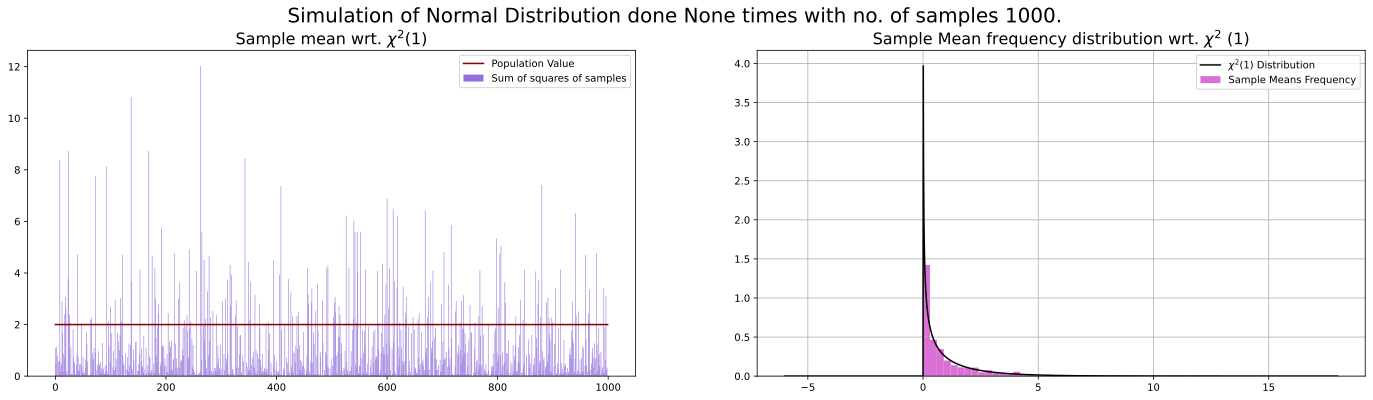

In [31]:
ChiSquaredSimulation(dof=1, no_of_random_variables=1000).run()

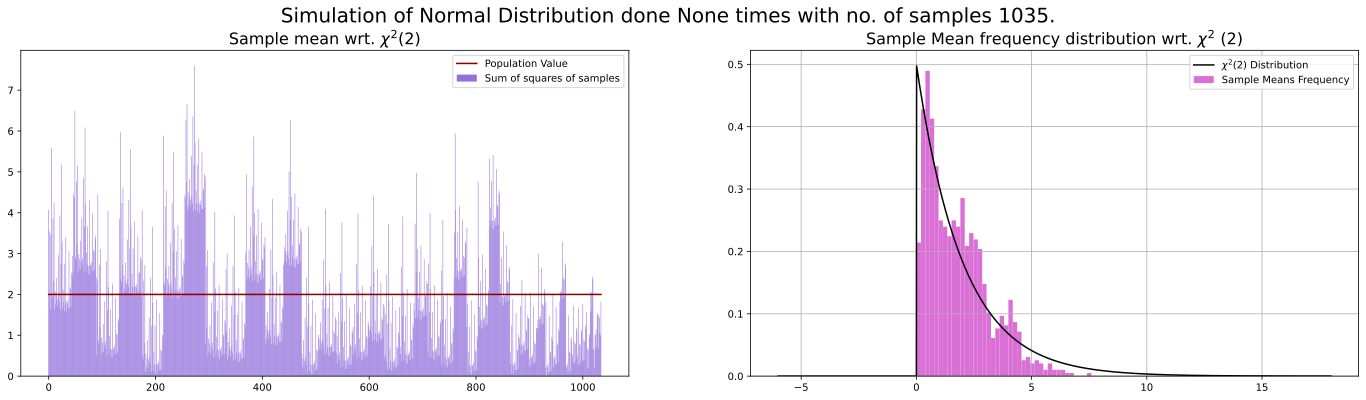

In [49]:
ChiSquaredSimulation(dof=2, no_of_random_variables=46).run()

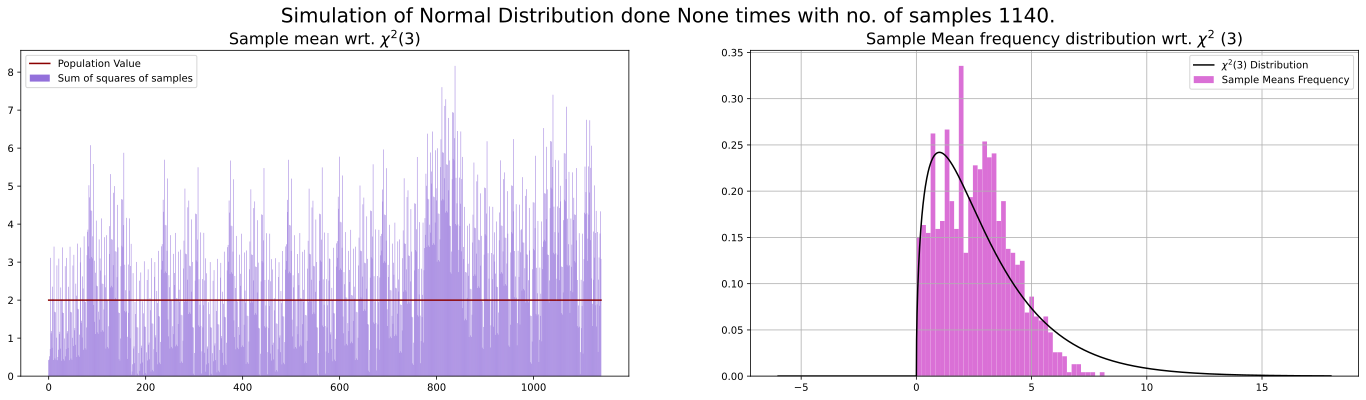

In [51]:
ChiSquaredSimulation(dof=3, no_of_random_variables=20).run()

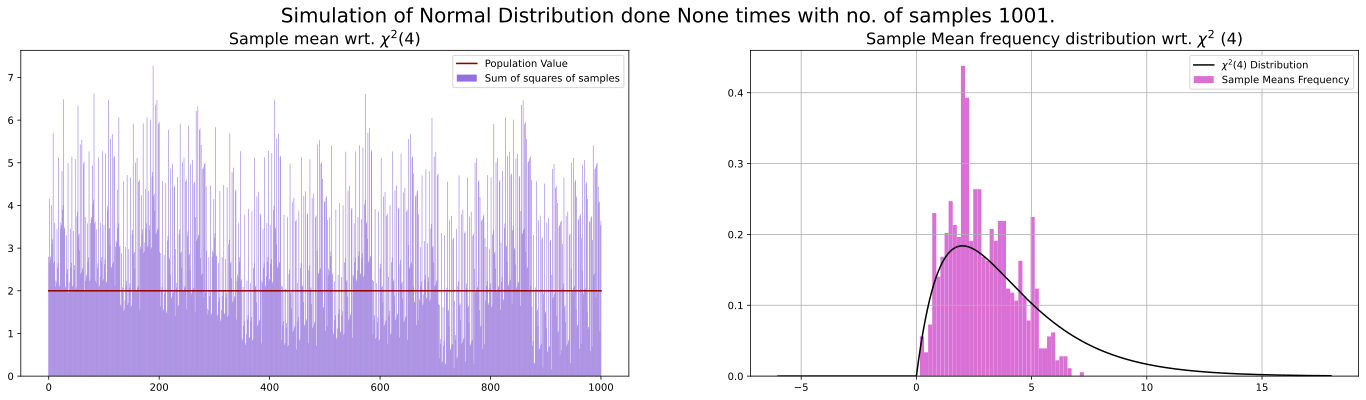

In [34]:
ChiSquaredSimulation(dof=4, no_of_random_variables=14).run()

### Observation from Simulation of $\chi^2$ distribution using random Normal variables
$$\chi^2(k) \approx \sum\limits_{i=1}^{k} X_i^2, \forall X_i \sim Normal(\mu=0, \sigma=1)$$
The $\chi^2(k)$ Distribution is approximately similar to sum of squares of $p$ random Normal variables.

It is evident from the graphs that for a large sample size $\chi^2(k)$ is good approximate for $\sum\limits_{i=1}^{k} X_i^2$.

## Simulation 2
Suppose $Z \sim N(0,1)$, $V \sim \chi^2(v)$, ν: Degrees of freedom, Let $t = \frac{Z}{\sqrt{(V/v)}}$; Simulate $t$ taking $\chi^2(v)$ as simulated from the previous question. (Take $v$=3, 5, 10, 15 etc).
Plot $t$ histograms for $v$=(3, 5, 10, 15). In the same plot show the standard normal
distribution $Z$ pdf. Try to infer about the relationship between $t$ distribution and standard
normal distribution $Z$.

### T Distribution Simulation for df = (3, 5, 10, 15)

In [35]:
class TSimulation:
    def __init__(self, dof, no_of_normals=33, no_of_chi_squared=33):
        self.dof = dof
        self.dist = T(dof)
        self.norm = Normal(0,1)
        self.chi2 = Chi2(dof)
        self.z_samples = Sample(Normal, self.norm.params, no_of_normals)
        self.v_samples = Sample(Chi2, self.chi2.params, no_of_chi_squared)
        self.no_of_normals = no_of_normals
        self.no_of_chi_squared = no_of_chi_squared
        self._data = None
        
    def generate_samples(self):
        self.z_samples.generate()
        self.v_samples.generate()
        self._data = np.array(list(map(lambda X: X[0]/sqrt(X[1]/self.dof), product(self.z_samples.data, self.v_samples.data))))

    def plot_normal_curve(self):
        """
        Plot a T Distribution pdf curve having 
          k = Degrees of freedom
        """
        mean, sd = self.dist.mean, math.sqrt(self.dist.variance)
        domain = (mean - 5 * sd, mean + 6 * sd)
        x = list(np.arange(*domain, 0.01))
        y = np.array(self.norm(x)).reshape(len(x), 1)
        plt.plot(x, y, '-', color='black', label=f'T(df={self.dof}) Distribution')
        plt.grid()
        
    def plot_sample_values(self, ax):    
        # List of Sample value
        x = np.array(range(len(self._data)))
        # and plot it
        ax.bar(x, self._data, 1, color="mediumpurple", label='Sum of squares of samples')
        ax.set_title(f'Sample Value wrt. Normal(μ={self.norm.mean}, σ={self.norm.standard_deviation})', size=16)
        # horizontal line indicating the Population Mean
        p_m, = ax.plot([x[0], x[-1]], [self.norm.mean, self.norm.mean], "-", color='darkred', label='Population Value')
        ax.legend()

    def plot_sample_values_distribution(self, ax):
        no_of_samples = len(self._data)
        ax.hist(self._data, density=True, bins=40, color='orchid', label='Sample Means Frequency')
        ax.set_title('Sample Mean frequency distribution wrt. N~(μ=0, σ=1)', size=16)
        self.plot_normal_curve()
        ax.legend()

    def run(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6), dpi=72)
        fig.suptitle(f'Simulation of {self.dist.name} Distribution done with no. of samples {self.no_of_normals * self.no_of_chi_squared}.', size=20)
        self.generate_samples()
        self.plot_sample_values(ax1)
        self.plot_sample_values_distribution(ax2)
        plt.show()

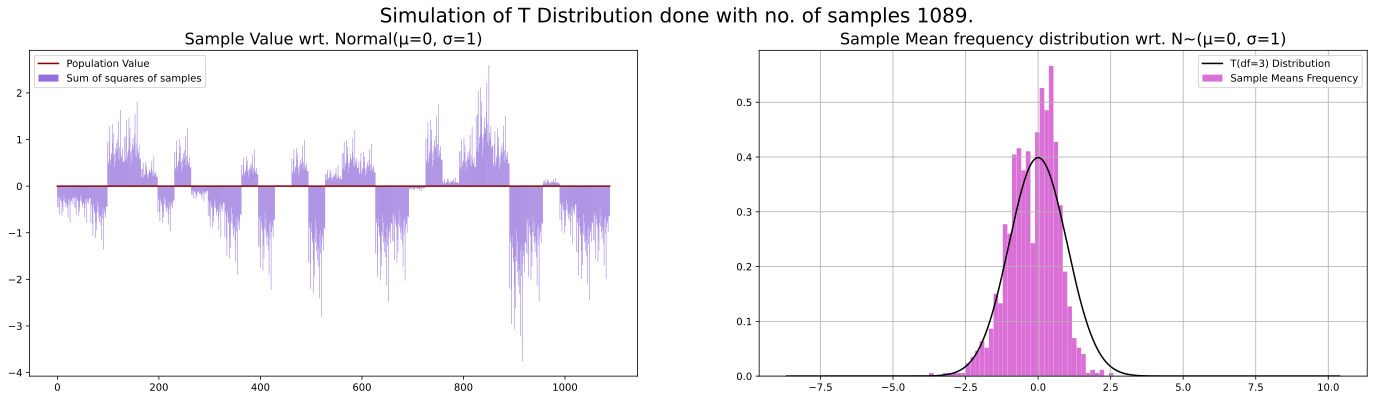

In [62]:
TSimulation(3).run()

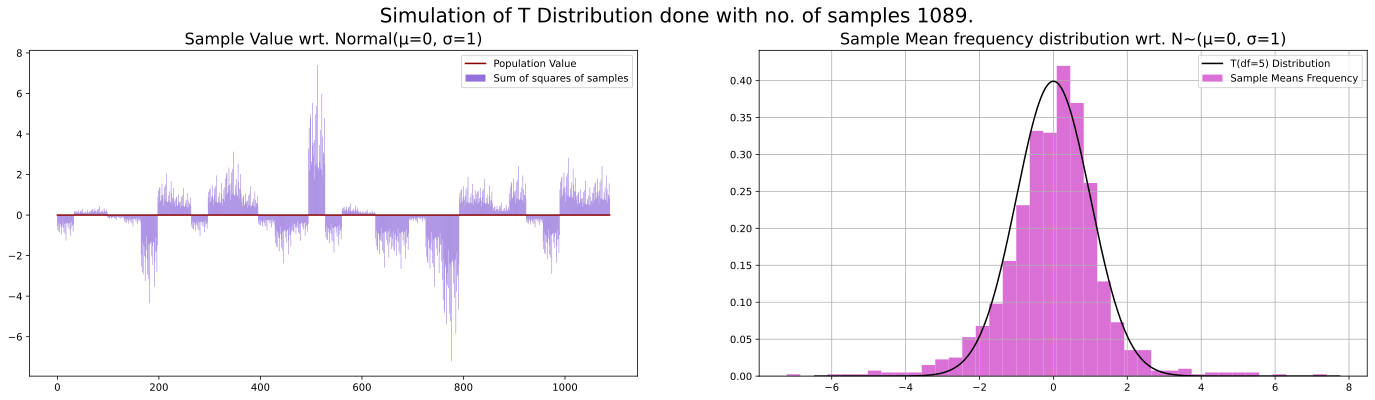

In [67]:
TSimulation(5).run()

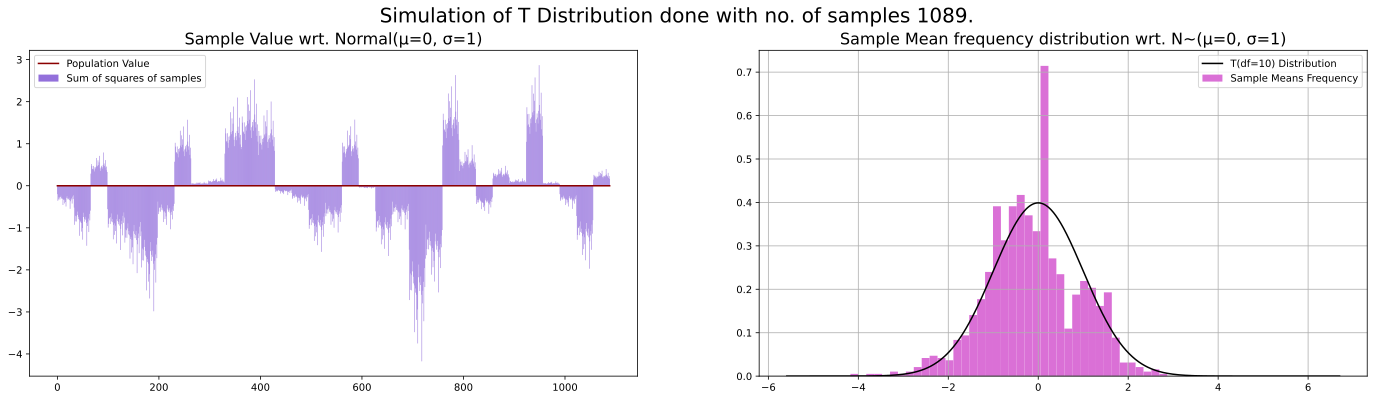

In [69]:
TSimulation(10).run()

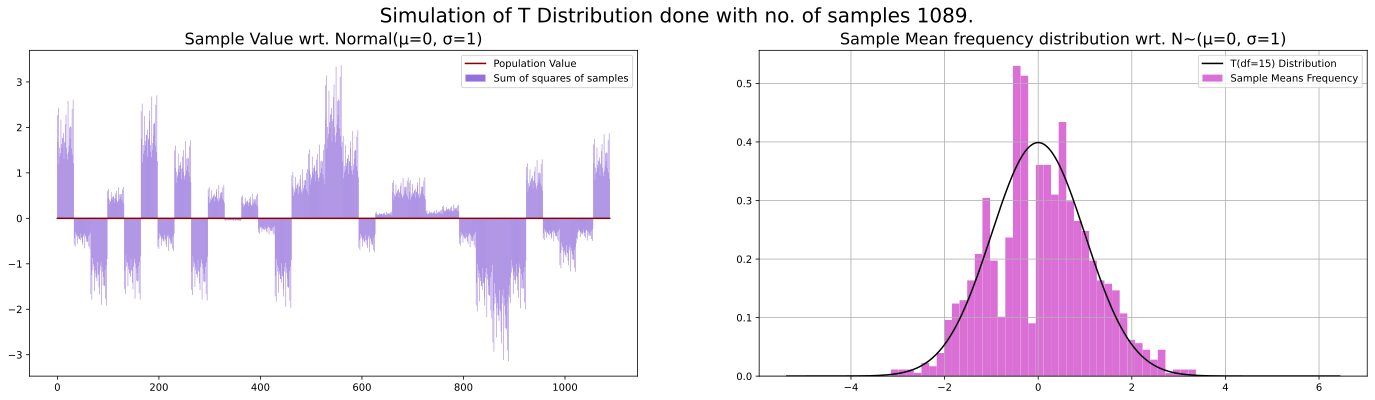

In [65]:
TSimulation(15).run()

### Observation from Simulation of T distribution using Normal and $\chi^2$ Random Variables
$$T(v) = \frac{Z}{\sqrt{(V/v)}}, \text{  where } Z\sim Normal(\mu=0, \sigma=1) \text{  and  } V\sim \chi^2(v)$$
The $T(v)$ Distribution is approximately similar to the division of random Normal Distribution $Z$ by $\sqrt{\frac{\chi^{2}(v)}{v}}$.


It is evident from the graphs that for a large sample size, the distribution of $T(v)$ is good approximate for $\frac{Z}{\sqrt{(V/ v)}}$.

## Simulation 3
$F(n_1,n_2)= (U_1/n_1)/(U_2/n_2)$;  
$U_1$ has $\chi^2$ distribution with n1 degrees of freedom.  
$U_2$ has $\chi^2$ distribution with $n_2$ degrees of freedom.  

Get the corresponding simulations for $\chi^2$ from question no. 1 and plot $F(2,3)$. Plot other $F$ histograms using the other $\chi^2$ data obtained in Q1 with different degrees of freedom.

### F Distribution Simulation for df's (2,3) (20,5) (25,50) (100,100)

In [40]:
class FSimulation:
    def __init__(self, dof_1, dof_2, no_of_chi_squared=33):
        self.dof_1 = dof_1
        self.dof_2 = dof_2
        self.dist = F(dof_1, dof_2)
        self.norm = Normal(0,1)
        self.chi2_1 = Chi2(dof_1)
        self.chi2_2 = Chi2(dof_2)
        self.u_samples = Sample(Chi2, self.chi2_1.params, no_of_chi_squared)
        self.v_samples = Sample(Chi2, self.chi2_2.params, no_of_chi_squared)
        self.no_of_chi_squared = no_of_chi_squared
        self._data = None
        
    def generate_samples(self):
        self.u_samples.generate()
        self.v_samples.generate()
        self._data = np.array(list(map(lambda X: (X[0]/self.dof_1)/(X[1]/self.dof_2), product(self.u_samples.data, self.v_samples.data))))

    def plot_f_curve(self):
        """
        Plot aF T Distribution pdf curve having 
          k = Degrees of freedom
        """
        mean, sd = self.dist.mean or 0, math.sqrt(self.dist.variance or 40)
        domain = (mean - 2 * sd, mean + 12 * sd)
        x = list(np.arange(*domain, 0.01))
        y = np.array(self.dist(x)).reshape(len(x), 1)
        plt.plot(x, y, '-', color='black', label=f'F(df1={self.dof_1}, df2={self.dof_2}) Distribution')
        plt.xlim(*domain)
        plt.grid()
        
    def plot_sample_values(self, ax):    
        # List of Sample value
        x = np.array(range(len(self._data)))
        # and plot it
        ax.bar(x, self._data, 1, color="mediumpurple", label='Sum of squares of samples')
        ax.set_title(f'Sample Value wrt. F(df1={self.dof_1}, df2={self.dof_2})', size=16)
        # horizontal line indicating the Population Mean
        p_m, = ax.plot([x[0], x[-1]], [self.dist.mean or 0, self.dist.mean or 0], "-", color='darkred', label='Population Value')
        ax.legend()

    def plot_sample_values_distribution(self, ax):
        no_of_samples = len(self._data)
        ax.hist(self._data, density=True, bins=64, color='orchid', label='Sample Means Frequency')
        ax.set_title(f'Sample Mean frequency distribution wrt. F~(df1={self.dof_1}, df2={self.dof_2})', size=16)
        self.plot_f_curve()
        ax.legend()

    def run(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6), dpi=72)
        fig.suptitle(f'Simulation of {self.dist.name} Distribution done with no. of samples {self.no_of_chi_squared * self.no_of_chi_squared}.', size=20)
        self.generate_samples()
        self.plot_sample_values(ax1)
        self.plot_sample_values_distribution(ax2)
        plt.show()

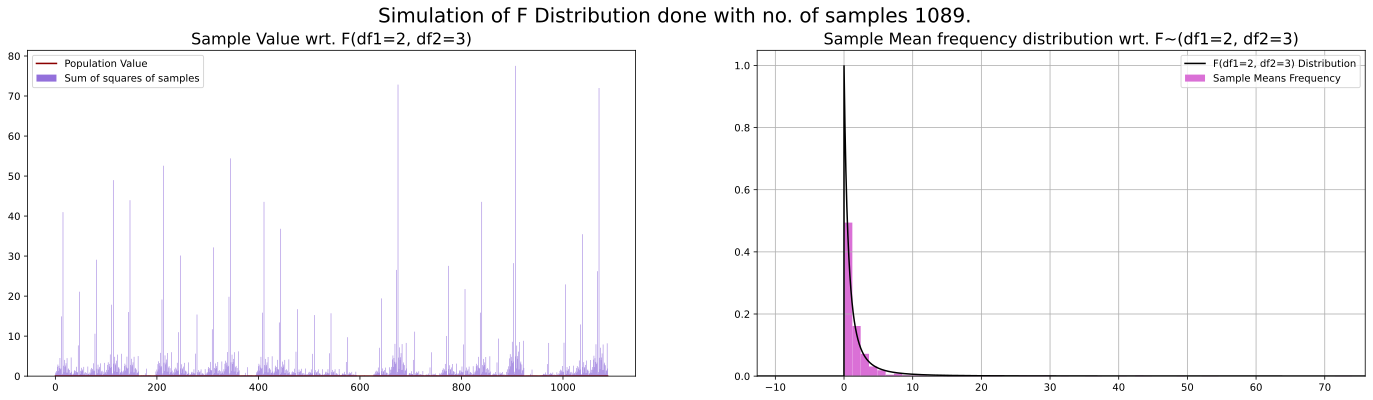

In [41]:
FSimulation(2, 3).run()

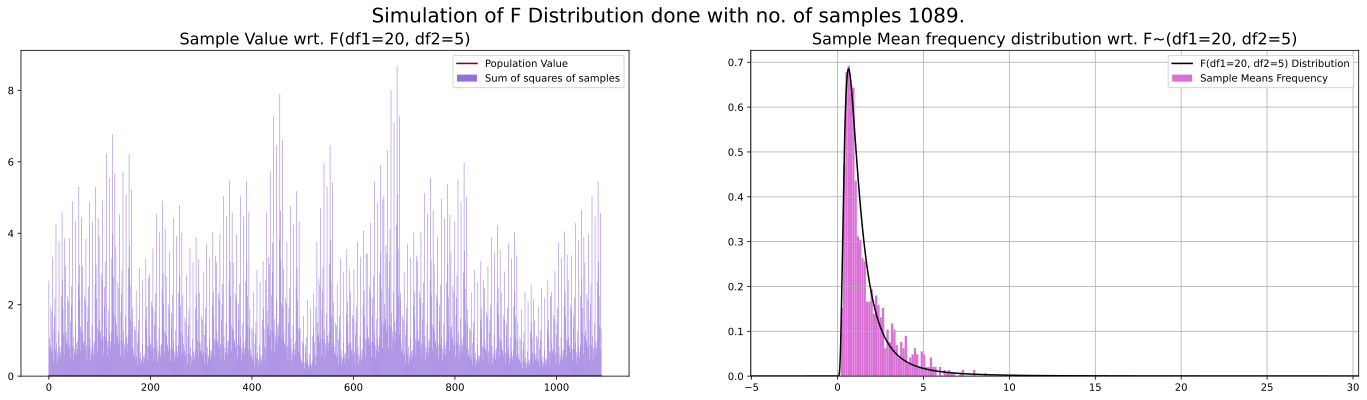

In [42]:
FSimulation(20, 5).run()

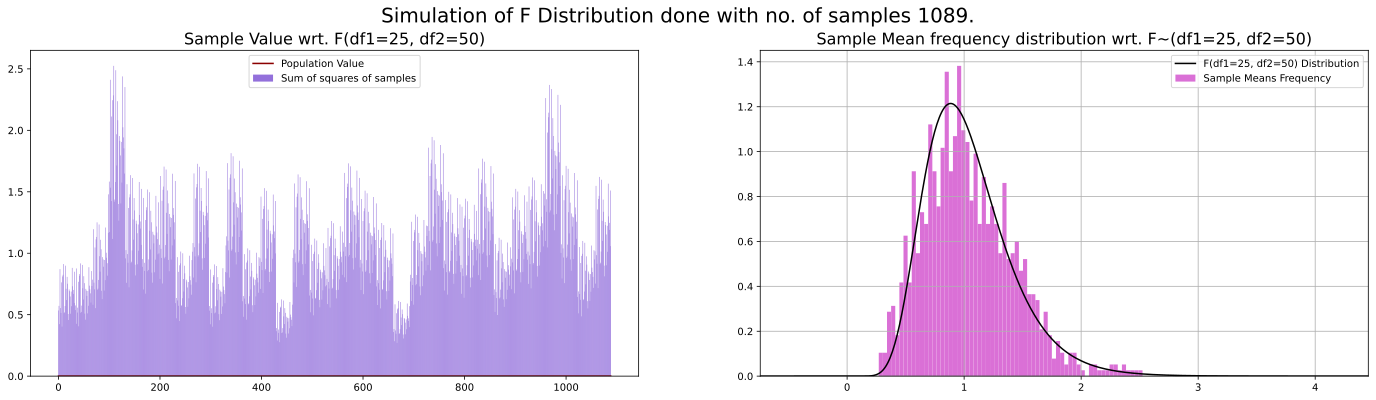

In [72]:
FSimulation(25, 50).run()

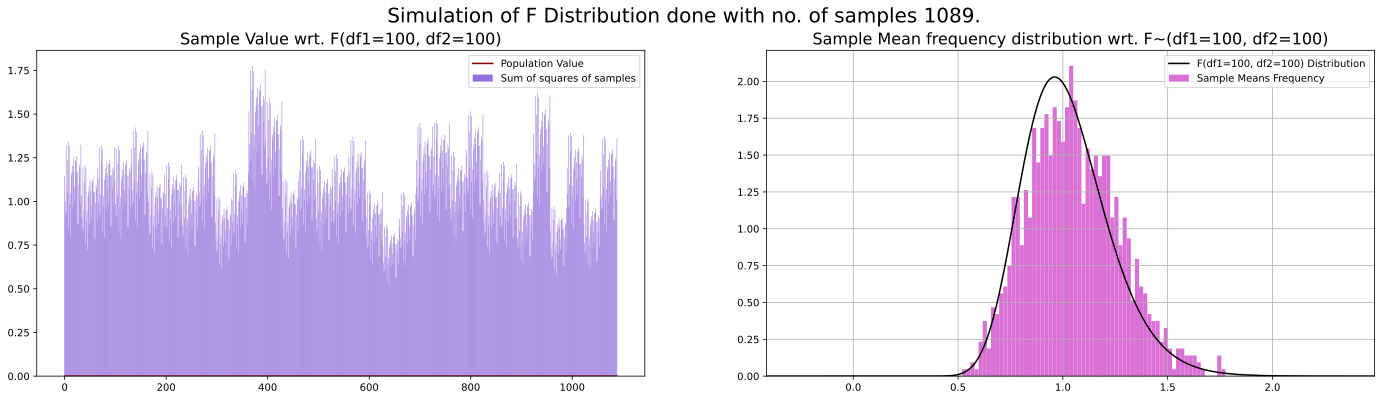

In [70]:
FSimulation(100, 100).run()

### Observation from Simulation of F distribution using two $\chi^2$ Random Variables
$$F(u,v) = \frac{(U/u)}{(V/v)}, \text{  where } U\sim \chi^2(u) \text{  and  } V\sim \chi^2(v)$$
The $F(u,v)$ Distribution is approximately similar to the ratio of two $\chi^2$ distribution with degree of freedom $u$ and $v$.

It is evident from the graphs that for a large sample size, the distribution of $F(u,v)$ is good approximate for $\frac{(U/u)}{(V/v)}$.

## Simulation 4
Simulate multivariate normal data for 3 variables and 100 observations.  
A. Check for univariate marginal tests by Q-Q plot.  
B. Check for bivariate and multivariate normality.  
The three Normal Distributions used are as follows:  
* Normal(0,1)
* Normal(7,4)
* Normal(-3,2)

### Check for univariate marginal tests by Q-Q plot.

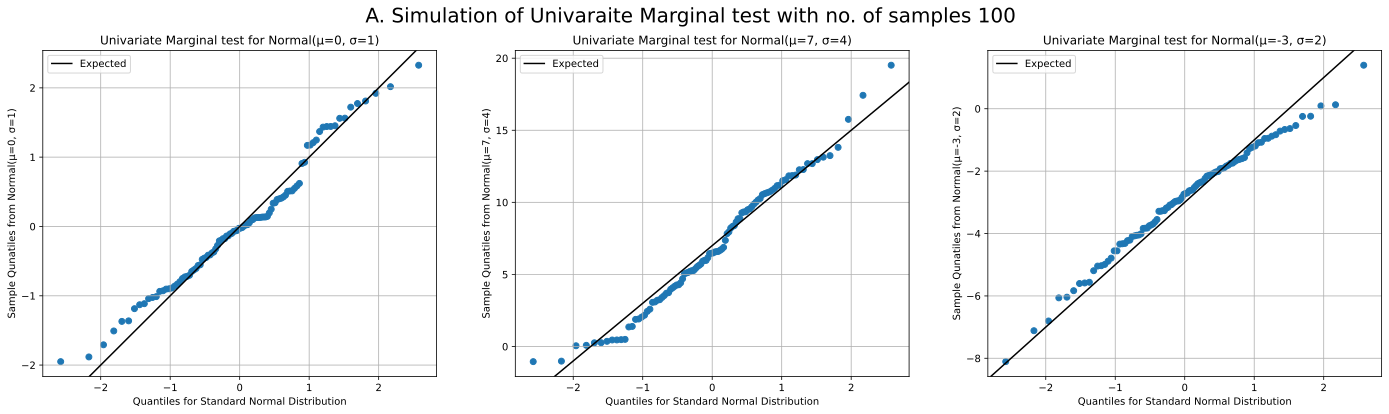

In [45]:
class MultivariteNormalSimulationA:
    def __init__(self, dists: List[Distribution], sample_size=100):
        self.no_of_normals = len(dists)
        self.norms = dists
        self.sample_size = sample_size
        self._data = None
        self.sample1 = Sample(Normal, dists[0].params, sample_size)
        self.sample2 = Sample(Normal, dists[1].params, sample_size)
        self.sample3 = Sample(Normal, dists[2].params, sample_size)
        self.sn_quantitles = None
        
    def generate_samples(self):
        self.sample1.generate()
        self.sample2.generate()
        self.sample3.generate()
        # self._data = np.array(list(product(self.sample1.data, self.sample2.data, self.sample3.data)))
        
    def get_normal_quantiles(self):
        if self.sn_quantitles is None:
            J = np.array(list(map(lambda j: (j-1/2)/self.sample_size, range(1,self.sample_size+1))))
            self.sn_quantitles = norm.ppf(J)
        return self.sn_quantitles
    
    def plot_univariate_qq_plot_for_distribution(self, ax, sample_no):
        mean, sd = self.norms[sample_no-1].mean, self.norms[sample_no-1].sd
        # List of Sample value
        samples = np.array(sorted(getattr(self, f'sample{sample_no}').data))
        # Find quantiles for self.sample_size for Normal
        sn_quantiles = self.get_normal_quantiles()
        # Find d^2 dist for samples
        # 2D scatter plot against x=y
        ax.scatter(sn_quantiles, samples)
        ax.axline((0, mean), (1, mean + sd), color='black', label='Expected')
        ax.grid()
        ax.set_xlabel('Quantiles for Standard Normal Distribution')
        ax.set_ylabel(f'Sample Qunatiles from {self.norms[sample_no-1]}')
        ax.set_title(f'Univariate Marginal test for {self.norms[sample_no-1]}')
        ax.legend()

    def run(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6), dpi=72)
        fig.suptitle(f'A. Simulation of Univaraite Marginal test with no. of samples {self.sample_size}', size=20)
        self.generate_samples()
        self.plot_univariate_qq_plot_for_distribution(ax1, 1)
        self.plot_univariate_qq_plot_for_distribution(ax2, 2)
        self.plot_univariate_qq_plot_for_distribution(ax3, 3)
        plt.show()

MultivariteNormalSimulationA((Normal(0,1), Normal(7,4), Normal(-3,2)), sample_size=100).run()

### Bivariate Normality Check

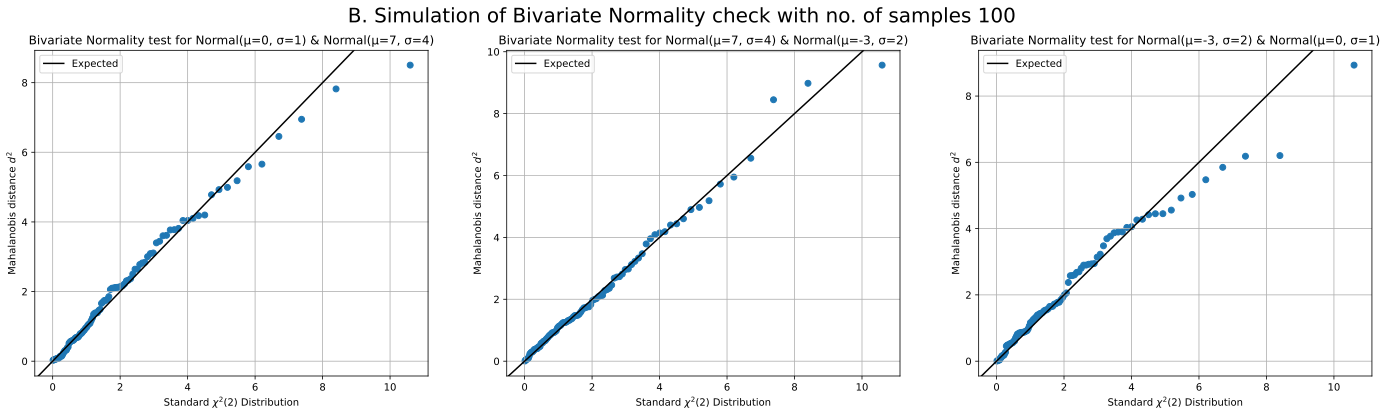

In [46]:
class MultivariteNormalSimulationB:
    def __init__(self, dists: List[Distribution], sample_size=100):
        self.no_of_normals = len(dists)
        self.norms = dists
        self.sample_size = sample_size
        self._data = None
        self.sample1 = Sample(Normal, dists[0].params, sample_size)
        self.sample2 = Sample(Normal, dists[1].params, sample_size)
        self.sample3 = Sample(Normal, dists[2].params, sample_size)
        self.sn_quantitles = None
        
    def generate_samples(self):
        self.sample1.generate()
        self.sample2.generate()
        self.sample3.generate()
        # self._data = np.array(list(product(self.sample1.data, self.sample2.data, self.sample3.data)))
        
    def get_chi2_quantiles(self):
        if self.sn_quantitles is None:
            J = np.array(list(map(lambda j: (j-1/2)/self.sample_size, range(1,self.sample_size+1))))
            self.sn_quantitles = chi2.ppf(J, df=2)
        return self.sn_quantitles

    def get_mahalanobis_distance(self, sample1, sample2):
        sample1, sample2 = np.array(sample1), np.array(sample2)
        x1_, x2_ = np.mean(sample1), np.mean(sample2)
        n, p = self.sample_size, 2
        W = np.array((sample1-x1_, sample2-x2_)).reshape(p, n)
        S_inv = np.linalg.inv(W.dot(W.transpose()))
        d2 = []
        for j in range(n):
            x_j = np.array((sample1[j] - x1_, sample2[j] - x2_))
            d2.append(x_j.transpose().dot(S_inv).dot(x_j))
        d2 = np.array(sorted(d2)) * n
        return d2
    
    def plot_bivariate_normality_for_distribution(self, ax, sample_1=1, sample_2=2):
        # List of Sample value
        sample1 = getattr(self, f'sample{sample_1}').data
        sample2 = getattr(self, f'sample{sample_2}').data
        # Find quantiles for self.sample_size for Normal
        sn_quantiles = self.get_chi2_quantiles()
        # Find d^2 dist for samples
        d2 = self.get_mahalanobis_distance(sample1, sample2)
        # 2D scatter plot against x=y
        ax.scatter(sn_quantiles, d2)
        ax.axline((0, 0), (1, 1), color='black', label='Expected')
        ax.grid()
        ax.set_xlabel('Standard $\chi^2(2)$ Distribution')
        ax.set_ylabel(f'Mahalanobis distance $d^2$')
        ax.set_title(f'Bivariate Normality test for {self.norms[sample_1-1]} & {self.norms[sample_2-1]}')
        ax.legend()

    def run(self):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6), dpi=72)
        fig.suptitle(f'B. Simulation of Bivariate Normality check with no. of samples {self.sample_size}', size=20)
        self.generate_samples()
        self.plot_bivariate_normality_for_distribution(ax1, 1, 2)
        self.plot_bivariate_normality_for_distribution(ax2, 2, 3)
        self.plot_bivariate_normality_for_distribution(ax3, 3, 1)
        plt.show()

MultivariteNormalSimulationB((Normal(0,1), Normal(7,4), Normal(-3,2)), sample_size=100).run()

### Multivariate Normality Check

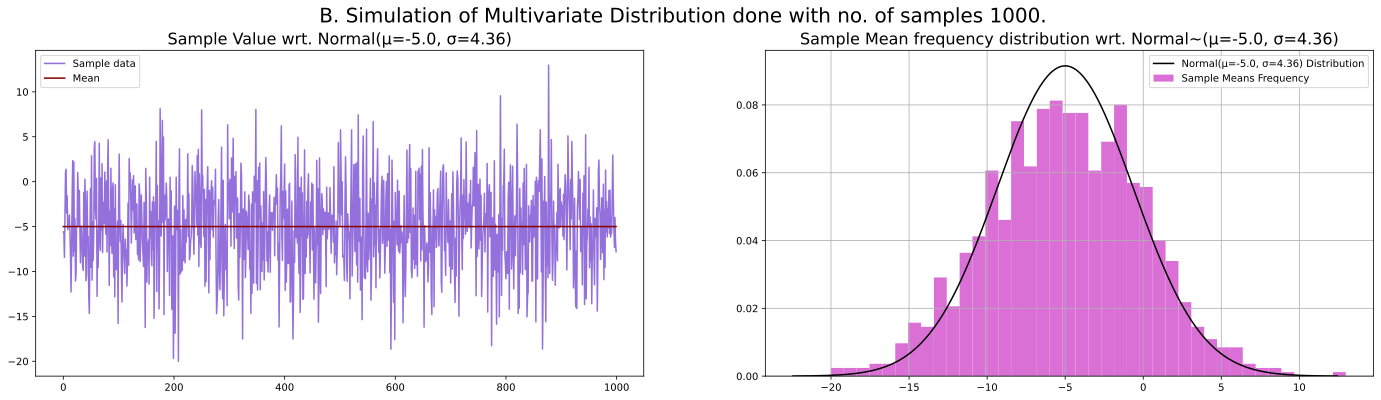

In [47]:
class MultivariteNormalSimulationB2:
    def __init__(self, dists: List[Distribution], sample_size=100):
        self.no_of_normals = len(dists)
        self.norms = dists
        self.sample_size = sample_size
        self._data = None
        self.sample1 = Sample(Normal, dists[0].params, sample_size)
        self.sample2 = Sample(Normal, dists[1].params, sample_size)
        self.sample3 = Sample(Normal, dists[2].params, sample_size)
        self.sn_quantitles = None
        
    def generate_samples(self, cv):
        self.sample1.generate()
        self.sample2.generate()
        self.sample3.generate()
        self._data = np.array(list(
            map(lambda x: float(cv.dot(np.array(x).reshape(3,1))),
            zip(self.sample1.data, self.sample2.data, self.sample3.data)
        )))

    def plot_normal_curve(self, mean, sd):
        """
        Plot a Normal pdf curve having 
          μ = Population.mean
          σ = Population.sd/√n
        """
        domain = (mean - 4 * sd, mean + 4 * sd)
        fun = norm(mean, sd).pdf
        x = list(np.arange(*domain, 0.01))
        y = list(map(fun, x))
        plt.plot(x, y, '-', color='black', label=f'Normal(μ={mean}, σ={sd:.2f}) Distribution')
        plt.grid()

    def plot_sample_values(self, ax, cv):
        # List of Sample value
        x = np.array(list(range(len(self._data))))
        # and plot it
        ax.plot(x, self._data, color="mediumpurple", label='Sample data')
        ax.set_title(f'Sample Value wrt. Normal(μ={self._mean}, σ={self._sd:.2f})', size=16)
        # horizontal line indicating the Population Mean
        p_m, = ax.plot([x[0], x[-1]], [self._mean, self._mean], "-", color='darkred', label='Mean')
        ax.legend()

    def plot_sample_values_distribution(self, ax, cv):
        no_of_samples = len(self._data)
        ax.hist(self._data, density=True, bins=40, color='orchid', label='Sample Means Frequency')
        ax.set_title(f'Sample Mean frequency distribution wrt. Normal~(μ={self._mean}, σ={self._sd:.2f})', size=16)
        self.plot_normal_curve(self._mean, self._sd)
        ax.legend(loc='upper right')
 
    def run(self, cv):
        cv = np.array(cv)
        self._mean = float(cv.dot(np.array(list(map(lambda x: x.mean, self.norms))).reshape(3,1)))
        self._sd = sqrt(cv.dot(np.array(list(map(lambda x: x.variance, self.norms))).reshape(3,1)))
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,6), dpi=72)
        fig.suptitle(f'B. Simulation of Multivariate Distribution done with no. of samples {self.sample_size}.', size=20)
        self.generate_samples(cv)
        self.plot_sample_values(ax1, cv)
        self.plot_sample_values_distribution(ax2, cv)
        plt.show()

MultivariteNormalSimulationB2((Normal(0,1), Normal(7,4), Normal(-3,1/2)), sample_size=1000).run(cv=(2,1,4))

### Observation from Simulation Multivariate Normal Distributions with 3 Normal Random Variables
A. The Univariate Normal test produced good approximation to standard Normal Distribution using the Q-Q Plot.  
B. The Bivariate test showed good approximation of Mahalanobis distance with $\chi^2(k)$.  
   The Multivariate test showed good approximation of linear combination of parameters with Normal Variables.  
